# Градиентные методы оптимизации
параметрических моделей машинного обучения

Для того, чтобы наслаждаться визуализациями этого ноутбука, следует установить пакет `plotly` (если он еще не установлен)

In [1]:
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from linear_regression_model import linear_regression
from data_generator import *
from sample_bootstrap import *

In [5]:
from mpl_toolkits.mplot3d import Axes3D

In [6]:
import plotly.graph_objects as go
import plotly.express as px

In [7]:
import itertools

In [8]:
from tqdm import tqdm

In [9]:
plt.rcParams['figure.figsize'] = (6,6)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['image.origin'] = 'lower'

Генерируем синтетическую задачу и посмотрим на данные

In [10]:
X,y,X_test,y_test = generate_data(cov_matrix=corr_coeff_2_cov_matr(corr_coeff=0.3), epsilon_var=0.2)

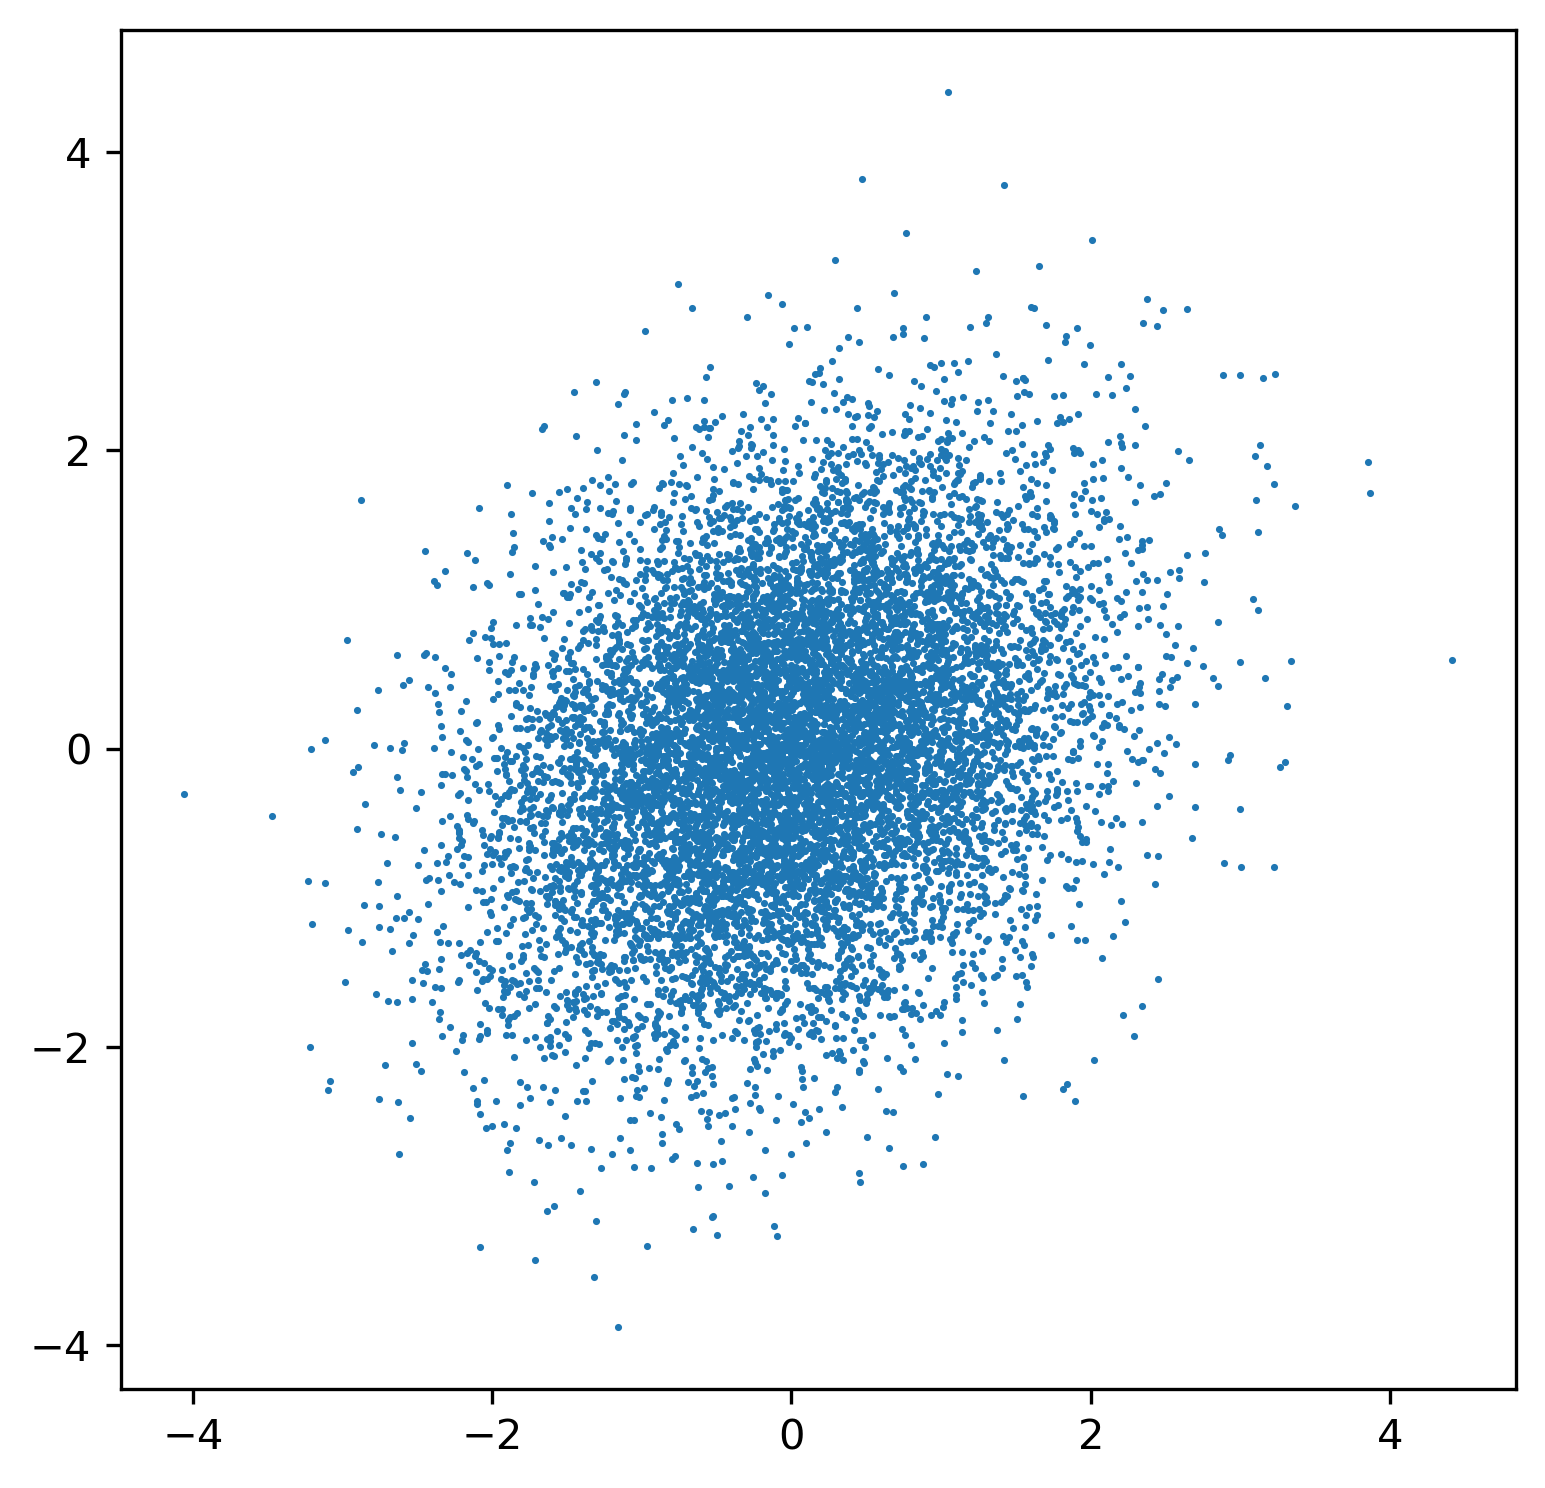

In [11]:
plt.scatter(X[:,0], X[:,1], s=0.5)
_ = plt.axis('equal')

In [ ]:
fig = go.Figure(data=[go.Scatter3d(x=X[:,0],
                                   y=X[:,1],
                                   z=y[:,0],
                                   mode='markers',
                                   marker=dict(size=1))
                     ])
fig.update_layout(autosize=False,
                  width=800,
                  height=800,
                  margin=go.layout.Margin(l=50, r=50, b=100, t=100, pad=4),
                  scene = dict(xaxis_title='x0',
                               yaxis_title='x1',
                               zaxis_title='y'))
fig.show()

Оцениваю среднее и разброс параметров с применением техники bootstrap

Это делать необязательно, здесь используется только для оценки пределов для отрисовки ландшафта функции ошибки

In [14]:
B = 1000
Nb = X.shape[0]
theta_values_curr_sample_size = []
for i in range(B):
    Xtrain,ytrain = sample_bootstrap(X,y, sample_size=Nb)
    lr = linear_regression()
    lr.fit(Xtrain,ytrain)
    theta_values_curr_sample_size.append(np.copy(lr.theta))
theta_values_curr_sample_size = np.concatenate([t.T for t in theta_values_curr_sample_size], axis=0)
theta_values_curr_sample_size.shape

(1000, 3)

In [15]:
t1_mean = np.mean(theta_values_curr_sample_size[:,1])
t1_min = np.min(theta_values_curr_sample_size[:,1])
t1_max = np.max(theta_values_curr_sample_size[:,1])
t1_range = (t1_max-t1_min)
t1_linspace = np.linspace(t1_mean-10*t1_range, t1_mean+10*t1_range, 200)

t2_mean = np.mean(theta_values_curr_sample_size[:,2])
t2_min = np.min(theta_values_curr_sample_size[:,2])
t2_max = np.max(theta_values_curr_sample_size[:,2])
t2_range = (t2_max-t2_min)
t2_linspace = np.linspace(t2_mean-10*t2_range, t2_mean+10*t2_range, 200)

задаем функцию ошибки loss(), которая будет обращаться к функции RMSE()

In [16]:
def RMSE(y_true, y_pred):
    return np.sqrt(np.sum(np.square(np.squeeze(np.asarray(y_true)) - np.squeeze(np.asarray(y_pred))))/y_pred.shape[0])

In [17]:
def loss(X_val,y_val,theta):
    lr = linear_regression()
    lr.theta = theta.reshape(X_val.shape[1]+1, 1)
    y_pred = lr.predict(X_val)
    l = RMSE(y_val, y_pred)
    return l

In [18]:
def loss_L2(X_val,y_val,theta):
    lr = linear_regression()
    lr.theta = theta.reshape(X_val.shape[1]+1, 1)
    y_pred = lr.predict(X_val)
    l = RMSE(y_val, y_pred) + 1e-3*np.sum(np.square(theta))
    return l

В полученных пределах (по параметрам $\theta^{(1)}$ и $\theta^{(2)}$) на сетке 200х200 посчитаем и отрисуем значения функции ошибки

In [19]:
t1_mesh,t2_mesh = np.meshgrid(t1_linspace, t2_linspace)
t0_mesh = np.ones_like(t1_mesh) * np.mean(theta_values_curr_sample_size[:,0])

In [20]:
theta_space = np.concatenate([t0_mesh[:,:,np.newaxis], t1_mesh[:,:,np.newaxis], t2_mesh[:,:,np.newaxis]], axis=-1)

In [21]:
loss_values = np.zeros_like(t1_mesh)
for i,j in itertools.product(np.arange(t1_linspace.shape[0]), np.arange(t2_linspace.shape[0])):
    curr_theta = theta_space[i,j,:]
    loss_values[i,j] = loss(X_test, y_test, curr_theta)

In [ ]:
fig = go.Figure(data=[go.Scatter3d(x = t1_mesh.ravel(),
                                   y = t2_mesh.ravel(),
                                   z = loss_values.ravel(),
                                   mode='markers',
                                   marker=dict(size=5,
                                               color=loss_values.ravel(),
                                               colorscale='jet',
                                               showscale=True,
                                               opacity=0.8))
                     ])
fig.update_layout(autosize=False,
                  width=800,
                  height=800,
                  margin=go.layout.Margin(l=50, r=50, b=100, t=100, pad=4),
                  yaxis = dict(scaleanchor = "x",
                               scaleratio = 1),
                  scene = dict(aspectmode='cube',
                               xaxis = dict(title='t1'),
                               yaxis = dict(title='t2'),
                               zaxis = dict(title='loss', range = [0.4, 0.8])))
# fig.show()

## Решение задачи линейной регрессии методом градиентной оптимизации

### Вспомним формулировку задачи и суть ее решения:

$$
x_i = (x_{i}^{(0)}, x_{i}^{(1)}, \dots, x_{i}^{(n)})
$$

$$
\theta = (\theta^{(0)}, \theta^{(1)}, \dots, \theta^{(n)})
$$

$$
\theta^* = \underset{\Theta}{\mathrm{argmin}} \sum_{i=1}^{N}{\left( y_i-\theta\cdot x_i \right)^2}
$$

Матрица объекты-признаки:

$$
X = \begin{bmatrix}
x_{0}^{(0)} & x_{0}^{(1)} & \dots & x_{0}^{(n)} \\
x_{1}^{(0)} & x_{1}^{(1)} & \dots & x_{1}^{(n)} \\
\dots \\
x_{N}^{(0)} & x_{N}^{(1)} & \dots & x_{N}^{(n)}
\end{bmatrix}
$$

Вектор-столбец целевой переменной:
$$
Y = \begin{bmatrix}
y_{0}\\
y_{1}\\
\dots \\
y_{N}
\end{bmatrix}
$$

Функция ошибки:

$$
\mathscr{L}(\theta, X, Y) = \left(Y-X\cdot\theta\right)^T\cdot(Y-X\cdot\theta) = \\
{Y^T}{Y}-2\theta^T{X^T}{Y}+\theta^T{X^T}{X}{\theta}
$$

Для решения численной оптимизацией потребуется градиент функции ошибки в отношении $\theta$:

$$
\frac{\partial{\mathscr{L}(\theta, X, Y)}}{\partial{\theta}} = -2{X^T}{Y} + 2{X^T}X\theta
$$

Для некоторых методов численной оптимизации (т.н. "второго порядка") может потребоваться матрица вторых производных - гессиан

$$
\frac{\partial^2 {\mathscr{L}(\theta, X, Y)}}{\partial\theta^2} = 2 X^T X
$$

### Основная идея градиентных методов оптимизации первого порядка:

Градиент функции ошибки $\nabla_{\theta}{\mathscr{L}(\theta, X, Y)}$ - направление, в котором функция возрастает быстрее всего. Направление против градиента (то есть, $-\nabla_{\theta}{\mathscr{L}(\theta, X, Y)}$) - направление, в котором функция **убывает** быстрее всего.

Значит, можно идти против градиента - и в конечном итоге придем в минимум (функции ошибки)!

### Важное замечание!
Не следует забывать, что в процессе оптимизации мы ищем минимум функции потерь **на пространстве параметров модели $\Theta$**. Обучающая выборка в этом процессе - зафиксированная данность! То есть, в этом процессе **меняется оценка параметров модели $\theta^*$**

# Метод градиентного спуска:

1. Выбрать начальное приближение для параметров $\theta_0$
2. Выбрать критерий останова: значение $\epsilon$ для изменения функции ошибки
3. Выбрать значение шага градиентного спуска ("темп обучения", "learning rate") $\eta$
4. Повторять до схождения:<br />
    а. Оценить градиент функции ошибки по формуле:
    $$
    \nabla_{\theta}{\mathscr{L}} = -2{X^T}{Y} + 2{X^T}X\theta^{(t)}
    $$
    <br />
    b. обновить вектор параметров модели по формуле:
    $$
    \theta^{(t+1)} = \theta^{(t)} - \eta*\nabla_{\theta}{\mathscr{L}}
    $$
    <br />
    c. проверить предикат останова:
    $$
    C = \left[ abs(\mathscr{L}^{(t+1)} - \mathscr{L}^{(t)} ) <= \epsilon \right]
    $$
    Прервать оптимизацию, если $C == 1$

# ЗАЧЕМ?!
Ведь модель и аналитически хорошо решается!

- не всякая модель решается аналитически уравнением $\nabla_{\theta}{\mathscr{L}} = 0 $
- градиентная оптимизация - общий подход, позволяющий строить модели потенциально любого рода, в которых нужно оптимизировать функционал ошибки или любой другой функционал. Некоторые модели машинного обучения принципиально формулируются от идеи градиентной оптимизации функционала эмпирического риска;
- не для всякого метода можно гарантировать выпуклую функцию ошибки; в некоторых методах ландшафт функции ошибки шумный и существенно невыпуклый, что сильно затрудняет или делает невозможным поиск аналитического решения задачи оптимизации: **даже** если мы можем аналитически найти точки $\theta$, в которых градиент обращается в ноль, - их скорее всего будет очень много, и лишь одна будет глобальным минимумом; а большинство из них вообще будут точками перегиба.

Итак, для градиентной оптимизации нам нужен градиент функции ошибки по параметрам $\theta$
Для линейной модели с квадратичной функцией ошибки градиент легко выписывается (см. выше)

Здесь определим функцию, которая будет его вычислять

In [23]:
def loss_grad(X,y,curr_theta):
    assert X.ndim == 2, "X should be 2-dimensional: (N of objects, n of features)"
    assert ((y.ndim == 2)&(y.shape[1] == 1)), "y should be 2-dimensional: (N of objects, one column)"
    
    X_0 = np.ones((X.shape[0], 1), dtype=np.float)
    X_matrix = np.concatenate([X_0, X], axis=1)
    y_column = np.squeeze(np.asarray(y)).reshape((-1,1))
    
    m1 = np.dot(X_matrix.T, y_column)
    m2 = np.dot(np.dot(X_matrix.T, X_matrix), curr_theta)
    grad = -2*m1 + 2*m2
    grad = grad/X.shape[0]
    return grad

In [24]:
Xtrain,ytrain = sample_bootstrap(X,y, sample_size=Nb)

In [31]:
theta0 = np.random.randn(X.shape[1]+1, 1)*0.2 + np.array(lr.theta)

In [32]:
theta_curr = theta0
grad_curr = loss_grad(Xtrain, ytrain, theta_curr)

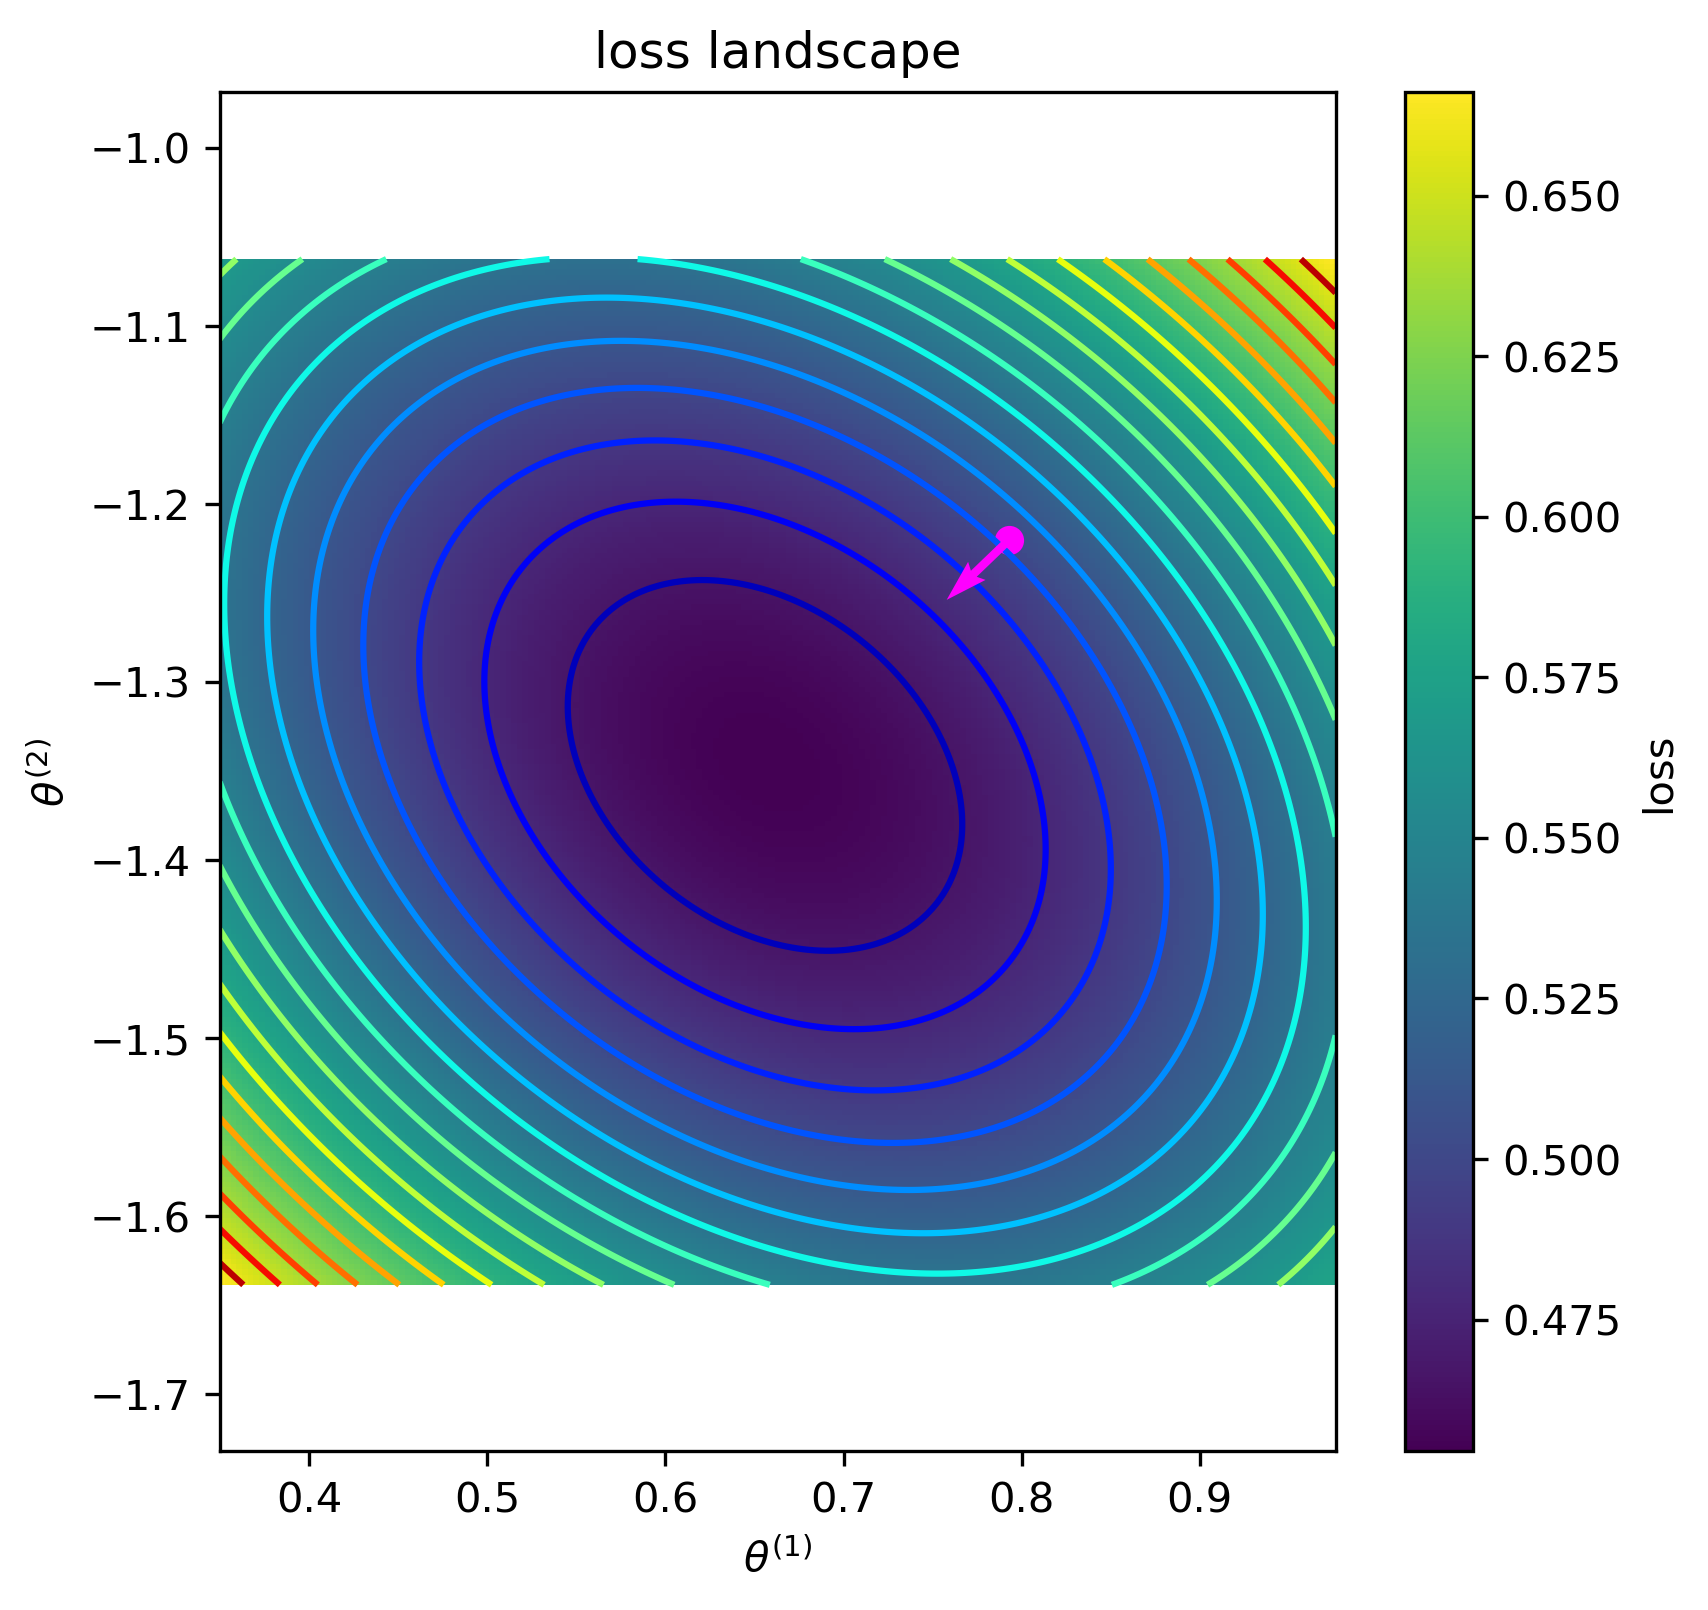

In [33]:
pcm = plt.pcolormesh(t1_mesh, t2_mesh, loss_values)
pc = plt.contour(t1_mesh,
                 t2_mesh,
                 loss_values,
                 levels = np.linspace(loss_values.min(),
                                      loss_values.max(), 20),
                 cmap='jet')
plt.axis('equal')
cb = plt.colorbar(pcm)
cb.set_label('loss')
plt.title('loss landscape')
plt.xlabel('$\\theta^{(1)}$')
plt.ylabel('$\\theta^{(2)}$')
plt.scatter(theta_curr[1], theta_curr[2], color='magenta')
_ = plt.quiver(theta_curr[1], theta_curr[2], -grad_curr[1], -grad_curr[2], units='xy', scale=10., color = 'magenta', zorder=10)

Нужно задать гиперпараметры: шаг обучения и константу $\epsilon$, используемую в условии останова.

In [34]:
eta = 0.01
eps = 0.0000001
# theta0 = np.random.randn(X.shape[1]+1, 1)*0.05 + np.array(lr.theta)

Дальше - собственно оптимизация

In [35]:
theta_history = []
loss_history = []
grad_history = []

theta_t = theta0
loss_t = loss(Xtrain, ytrain, theta_t)

it = 0

while True:
    it += 1    
    grad_t = loss_grad(Xtrain, ytrain, theta_t)
    theta_t_plus_1 = theta_t - eta*grad_t
    loss_t_plus_1 = loss(Xtrain, ytrain, theta_t_plus_1)
    
    C = np.abs(loss_t_plus_1 - loss_t) < eps
    
    theta_history.append(theta_t)
    loss_history.append(loss_t)
    grad_history.append(grad_t)
    
    loss_t = loss_t_plus_1
    theta_t = theta_t_plus_1
    
    if C & (it > 1):
        break
    
    if it > 1000:
        break

In [36]:
grad_t

array([[-0.00290965],
       [ 0.00019422],
       [ 0.00057659]])

In [37]:
len(loss_history)

252

Отрисуем траекторию в пространстве параметров, по которой была проведена оптимизация

Text(0.5, 1.0, 'optimization history')

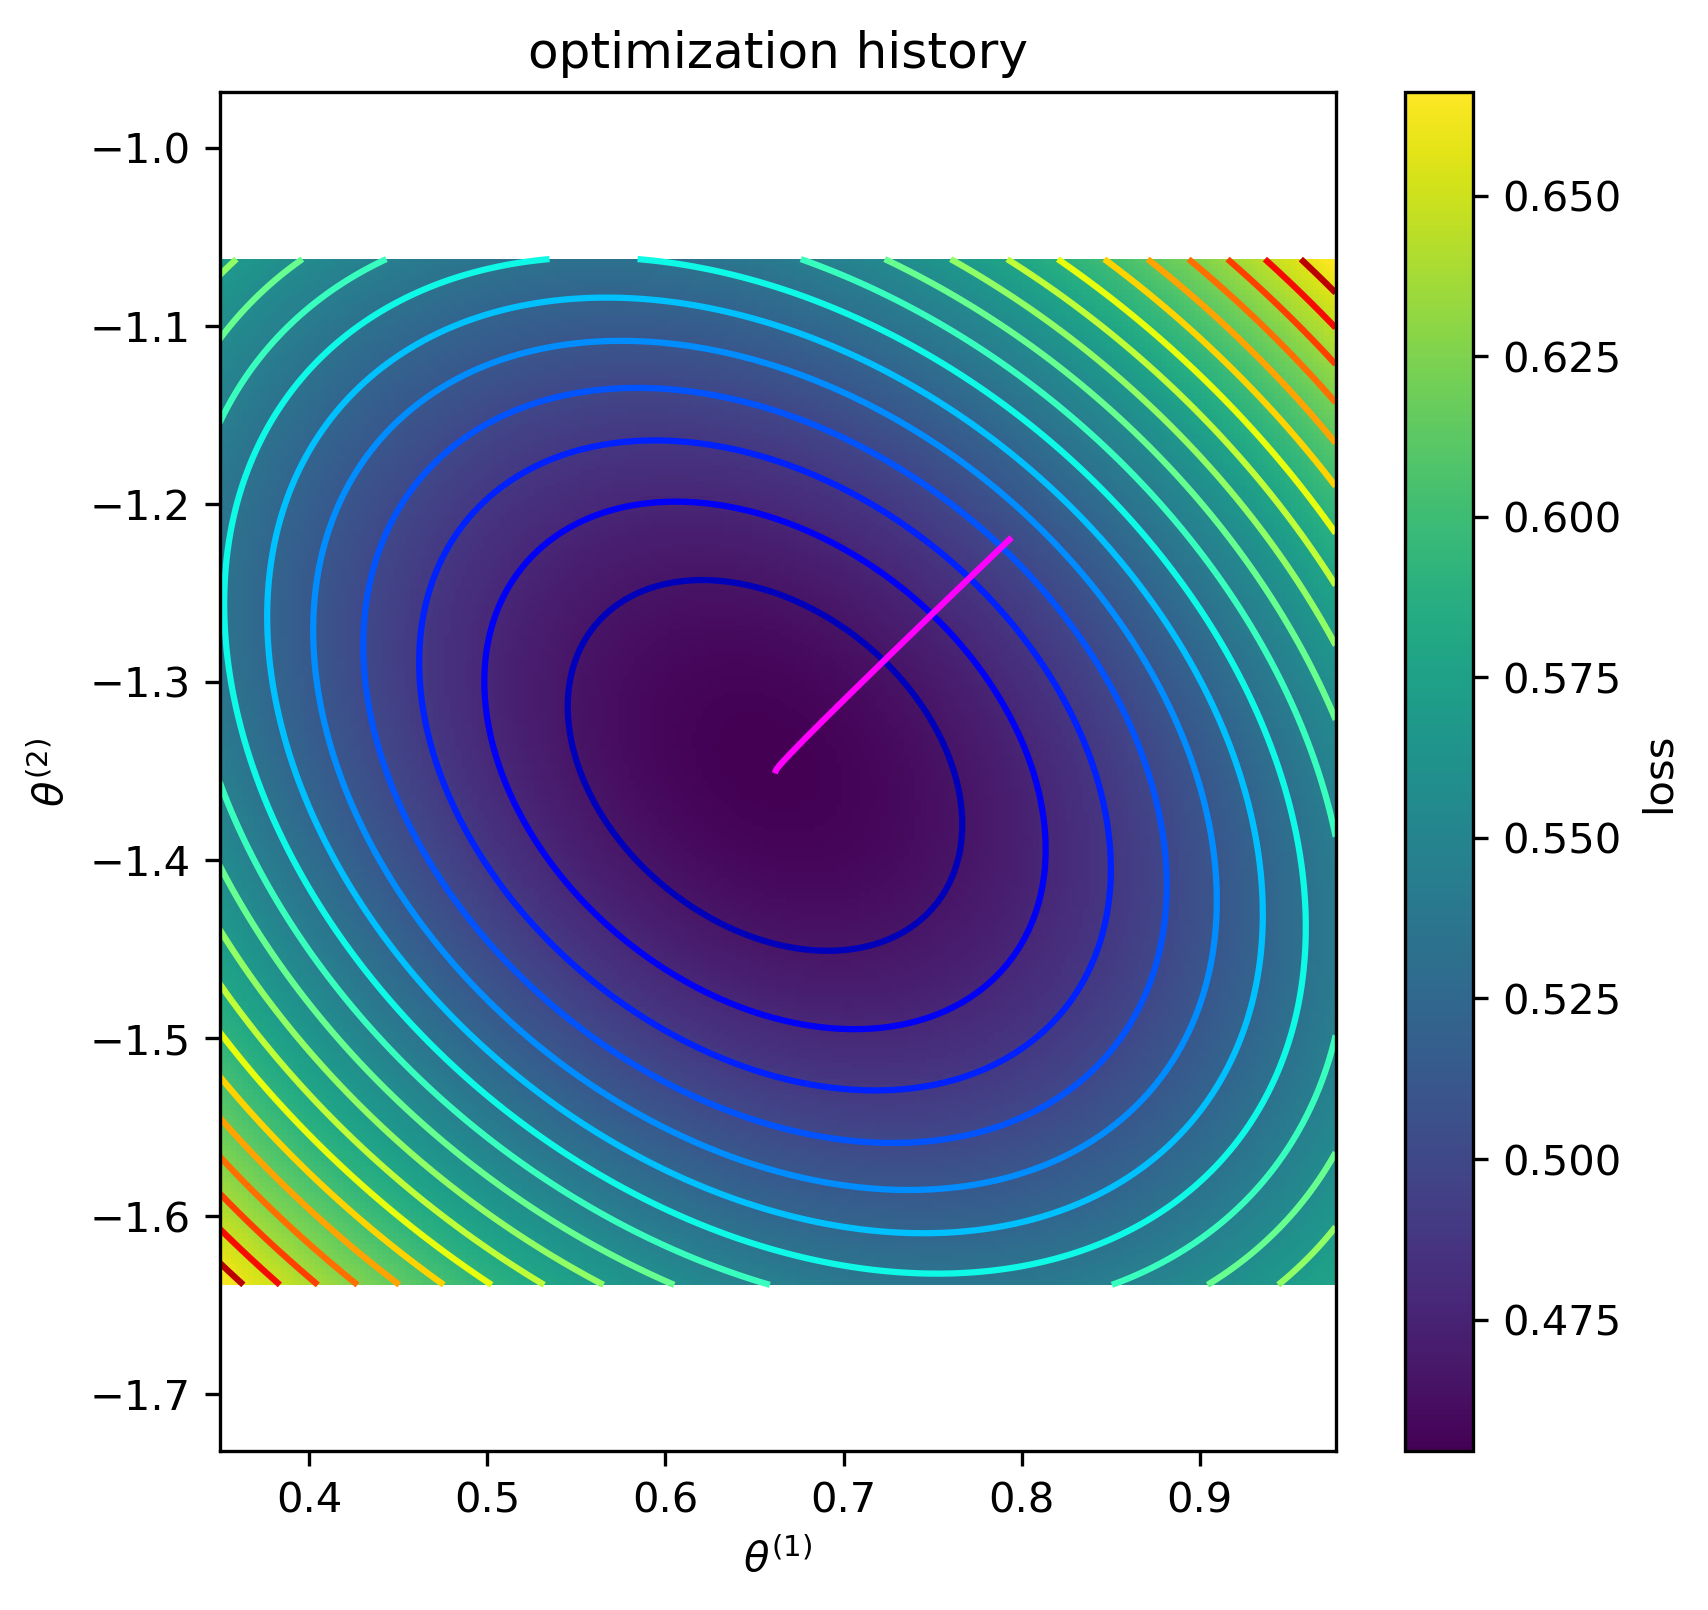

In [38]:
pcm = plt.pcolormesh(t1_mesh, t2_mesh, loss_values)
plt.contour(t1_mesh,
            t2_mesh,
            loss_values,
            levels = np.linspace(loss_values.min(),
                                 loss_values.max(), 20),
            cmap='jet')
plt.xlabel('$\\theta^{(1)}$')
plt.ylabel('$\\theta^{(2)}$')

cb = plt.colorbar(pcm)
cb.set_label('loss')

plt.plot([t[1] for t in theta_history], 
         [t[2] for t in theta_history], color='magenta')

_ = plt.axis('equal')
plt.title('optimization history')

Для контроля убедимся, что функция ошибки действительно убывает в процессе оптимизации

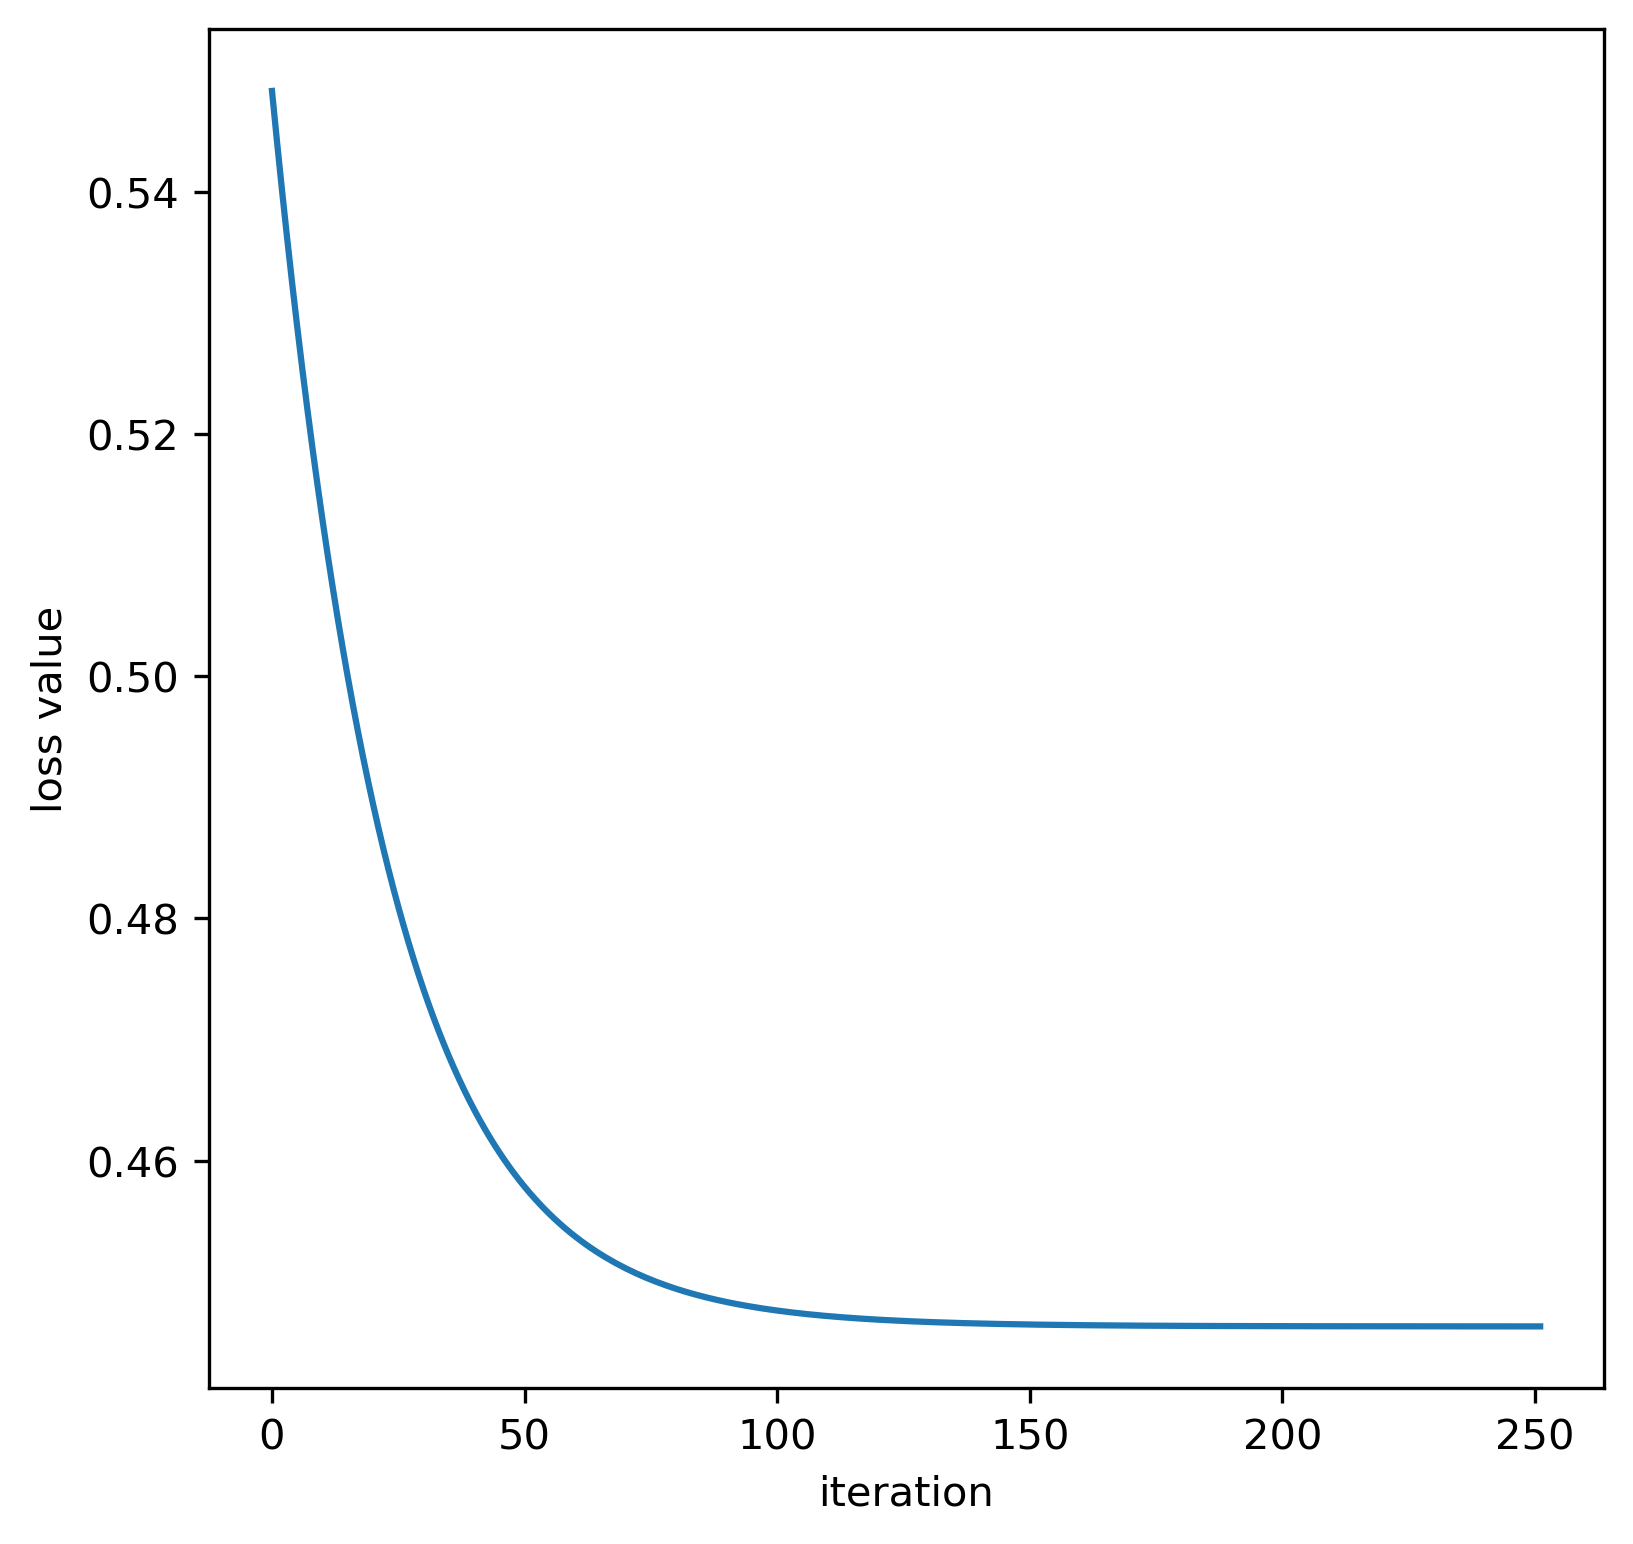

In [39]:
plt.plot(np.arange(len(loss_history)), np.array(loss_history))
plt.xlabel('iteration')
_ = plt.ylabel('loss value')

### Что будет, если $\eta$ взять побольше?

In [40]:
eta = 0.05
eps = 0.0000001

In [41]:
theta_history = []
loss_history = []
grad_history = []

theta_t = theta0
loss_t = loss(Xtrain, ytrain, theta_t)

it = 0

while True:
    it += 1    
    grad_t = loss_grad(Xtrain, ytrain, theta_t)
    theta_t_plus_1 = theta_t - eta*grad_t
    loss_t_plus_1 = loss(Xtrain, ytrain, theta_t_plus_1)
    
    C = np.abs(loss_t_plus_1 - loss_t) < eps
    
    theta_history.append(theta_t)
    loss_history.append(loss_t)
    grad_history.append(grad_t)
    
    loss_t = loss_t_plus_1
    theta_t = theta_t_plus_1
    
    if C & (it > 1):
        break
    
    if it > 1000:
        break

In [42]:
len(loss_history)

57

### Сошлось побыстрее!

Text(0.5, 1.0, 'optimization history')

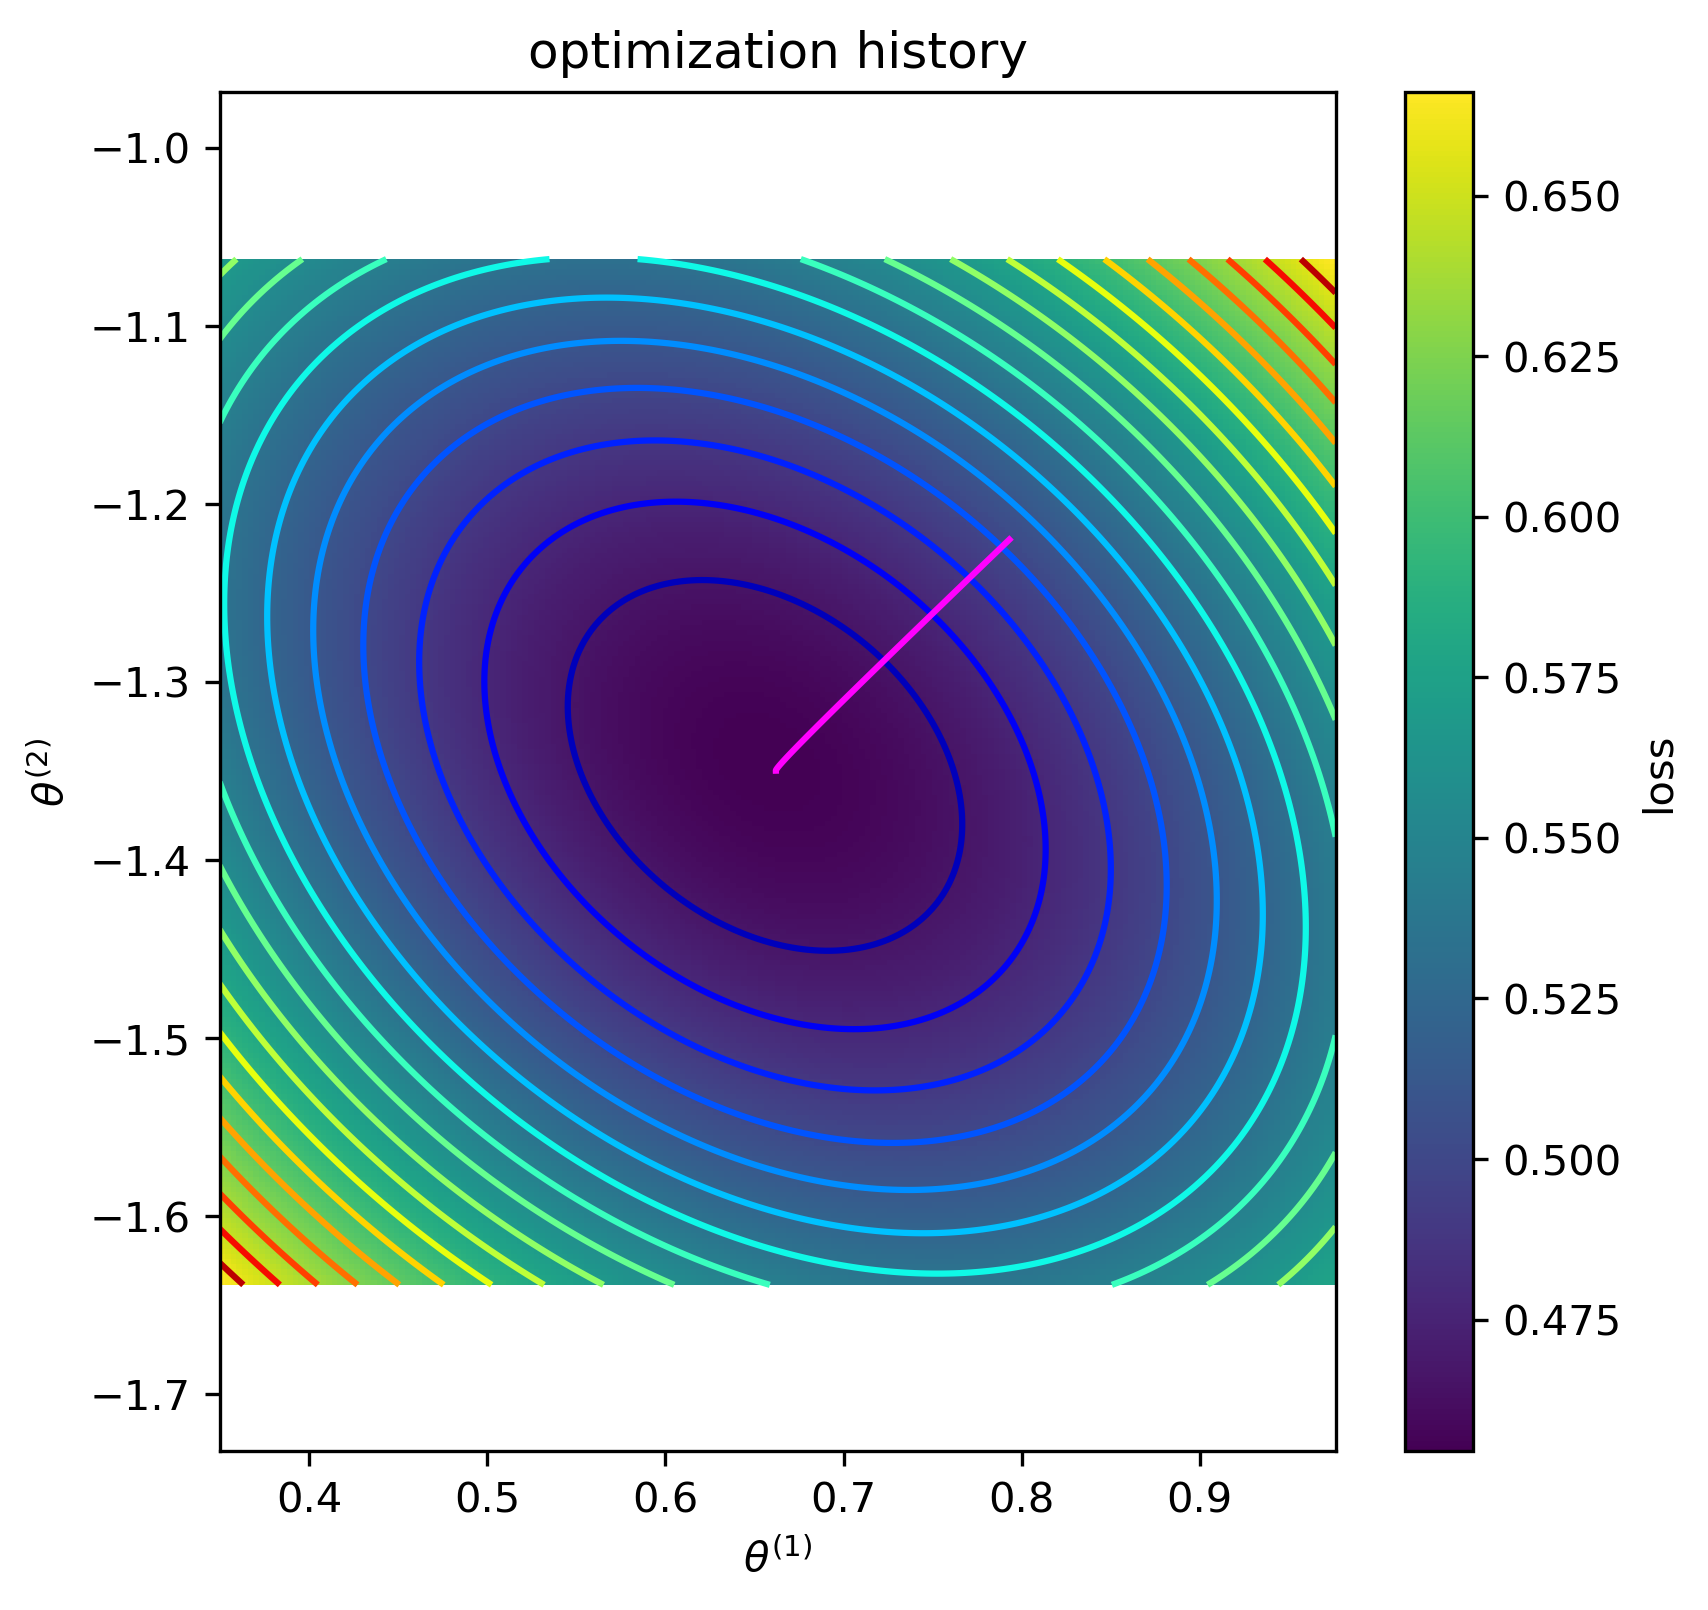

In [43]:
pcm = plt.pcolormesh(t1_mesh, t2_mesh, loss_values)
plt.contour(t1_mesh,
            t2_mesh,
            loss_values,
            levels = np.linspace(loss_values.min(),
                                 loss_values.max(), 20),
            cmap='jet')
plt.xlabel('$\\theta^{(1)}$')
plt.ylabel('$\\theta^{(2)}$')

cb = plt.colorbar(pcm)
cb.set_label('loss')

plt.plot([t[1] for t in theta_history], 
         [t[2] for t in theta_history], color='magenta')

_ = plt.axis('equal')
plt.title('optimization history')

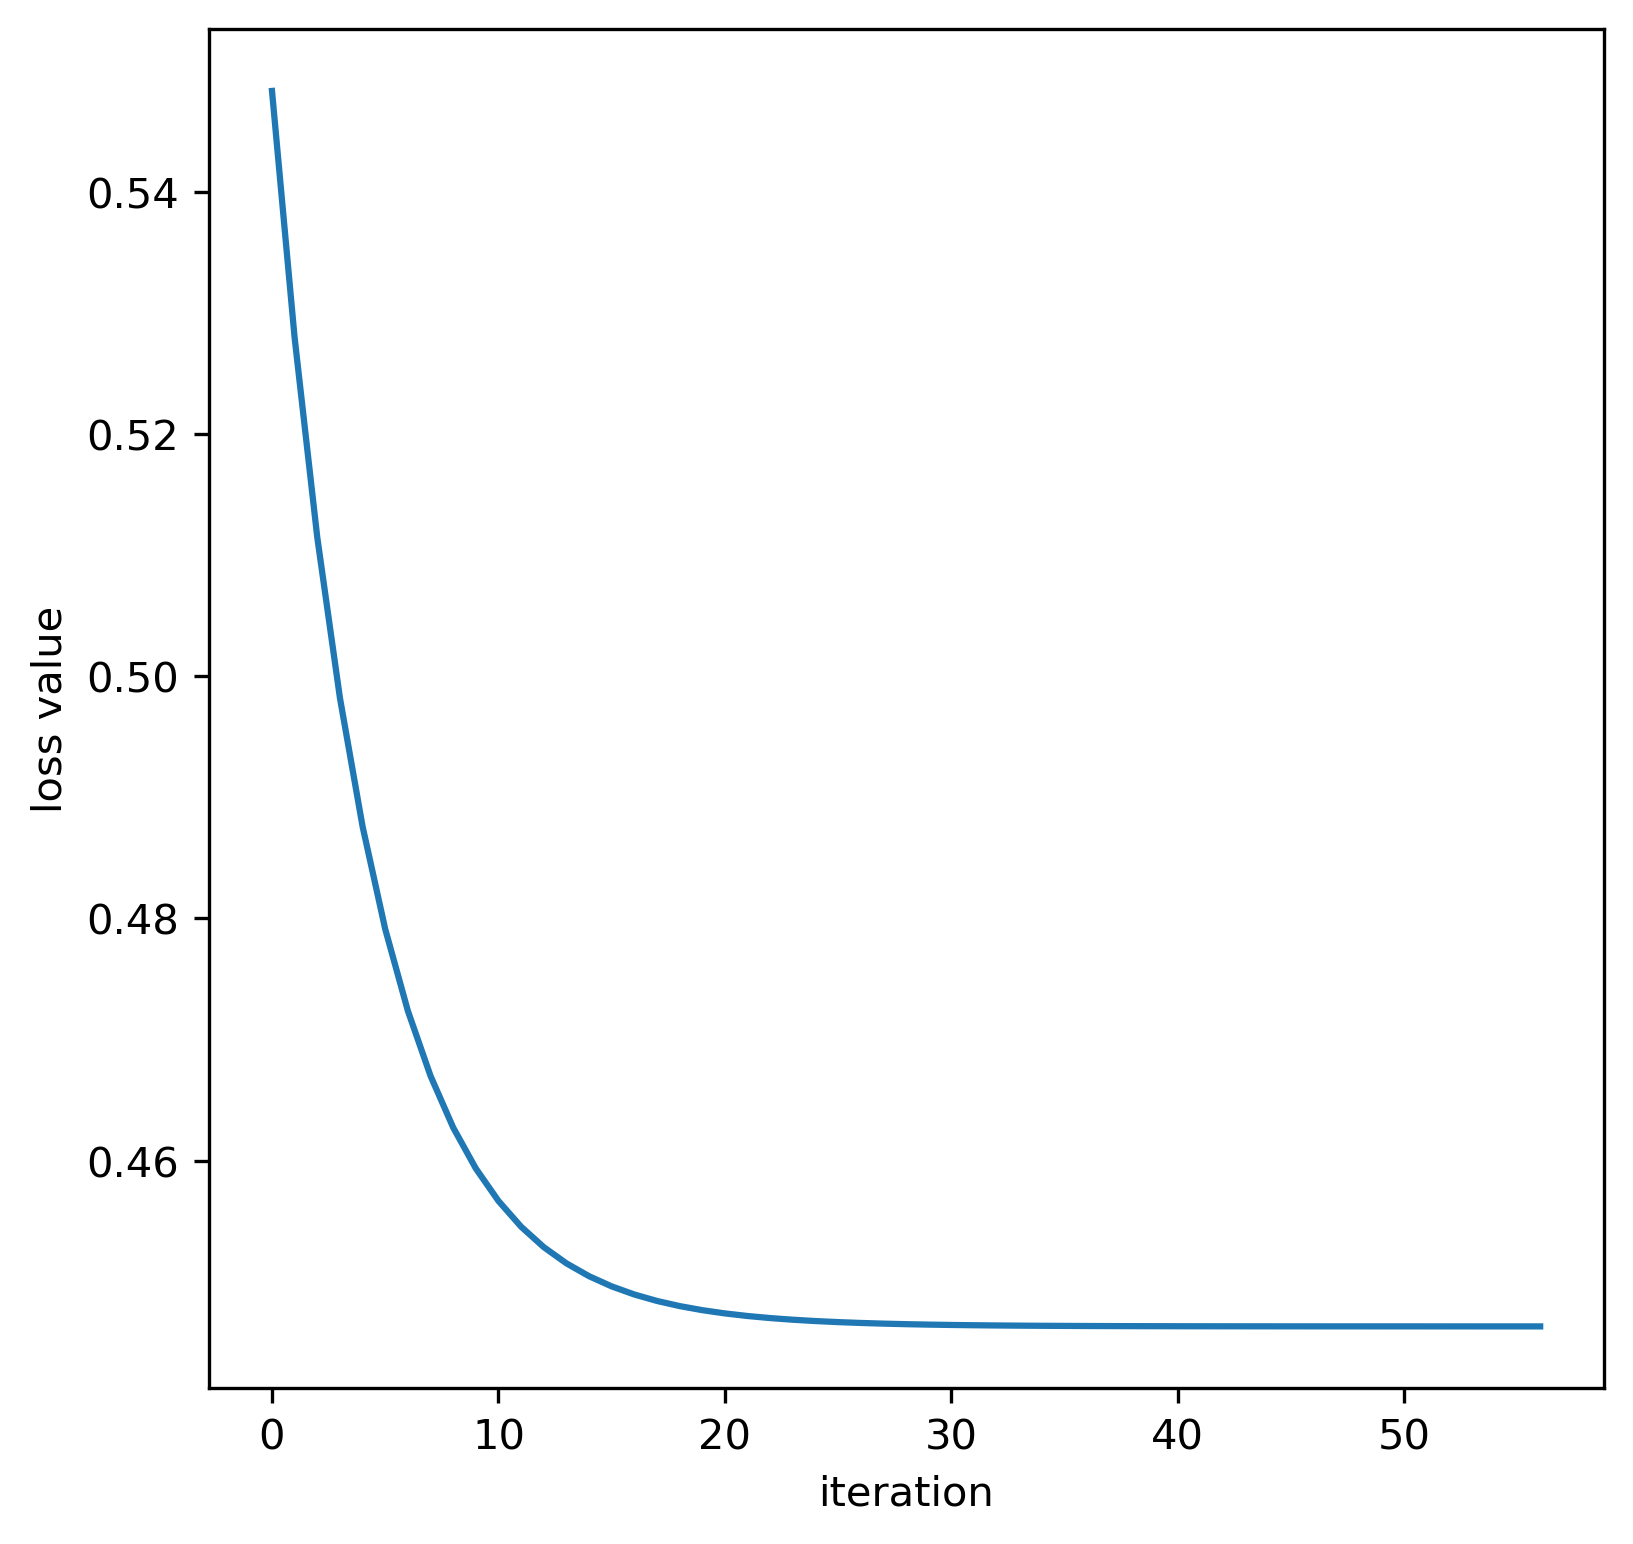

In [44]:
plt.plot(np.arange(len(loss_history)), np.array(loss_history))
plt.xlabel('iteration')
_ = plt.ylabel('loss value')

### Возьмем $\eta$ еще побольше

In [45]:
eta = 0.6
eps = 0.0000001

In [46]:
theta_history = []
loss_history = []
grad_history = []

theta_t = theta0
loss_t = loss(Xtrain, ytrain, theta_t)

it = 0

while True:
    it += 1    
    grad_t = loss_grad(Xtrain, ytrain, theta_t)
    theta_t_plus_1 = theta_t - eta*grad_t
    loss_t_plus_1 = loss(Xtrain, ytrain, theta_t_plus_1)
    
    C = np.abs(loss_t_plus_1 - loss_t) < eps
    
    theta_history.append(theta_t)
    loss_history.append(loss_t)
    grad_history.append(grad_t)
    
    loss_t = loss_t_plus_1
    theta_t = theta_t_plus_1
    
    if C & (it > 1):
        break
    
    if it > 1000:
        break

In [47]:
len(loss_history)

13

Text(0.5, 1.0, 'optimization history')

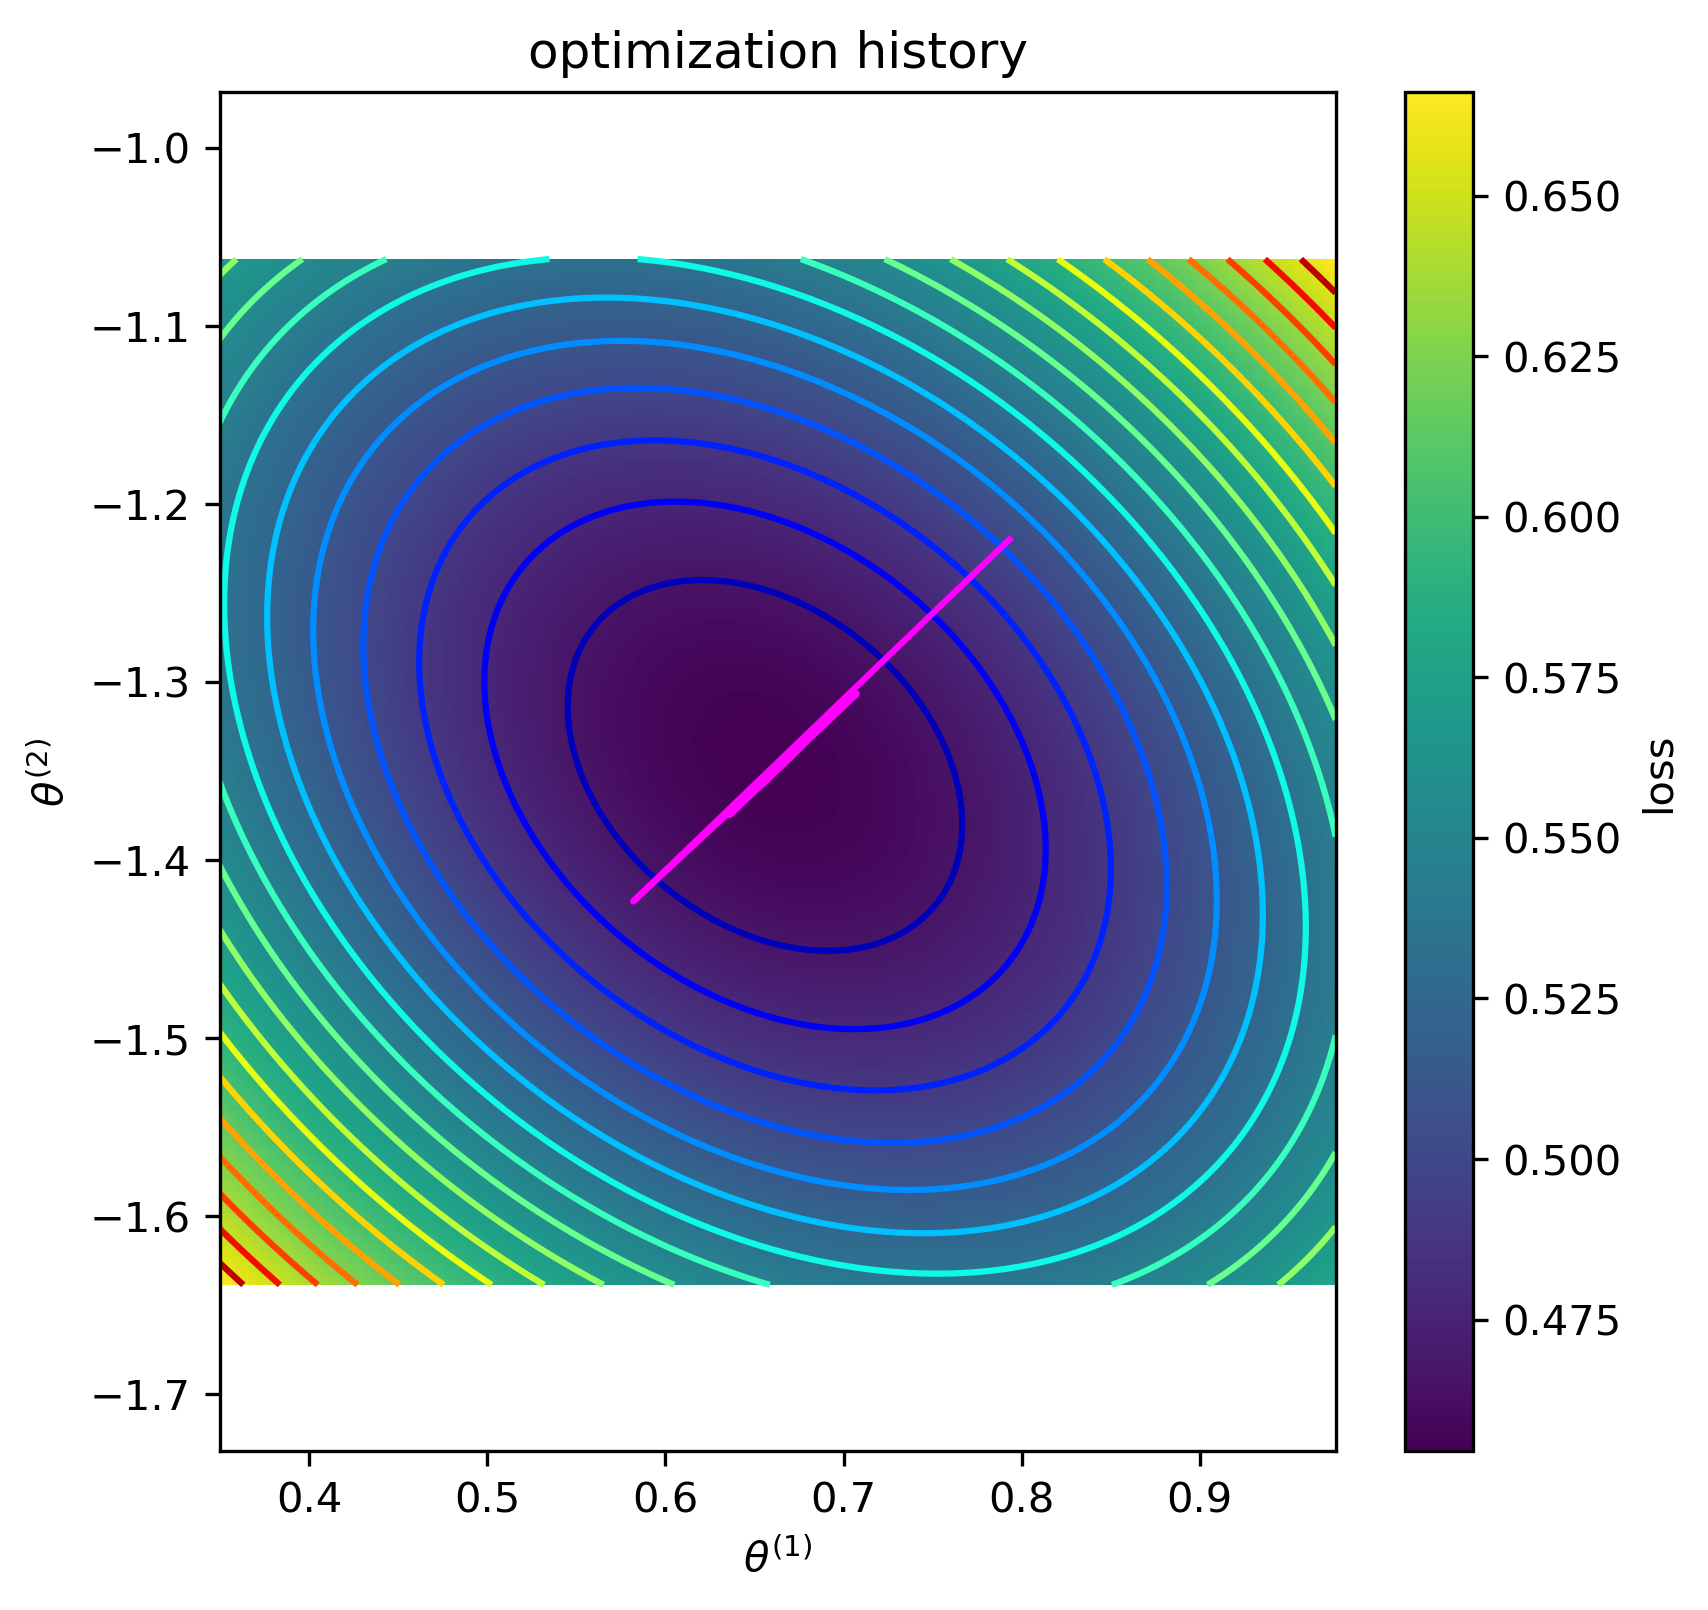

In [48]:
pcm = plt.pcolormesh(t1_mesh, t2_mesh, loss_values)
plt.contour(t1_mesh,
            t2_mesh,
            loss_values,
            levels = np.linspace(loss_values.min(),
                                 loss_values.max(), 20),
            cmap='jet')
plt.xlabel('$\\theta^{(1)}$')
plt.ylabel('$\\theta^{(2)}$')

cb = plt.colorbar(pcm)
cb.set_label('loss')

plt.plot([t[1] for t in theta_history], 
         [t[2] for t in theta_history], color='magenta')

_ = plt.axis('equal')
plt.title('optimization history')

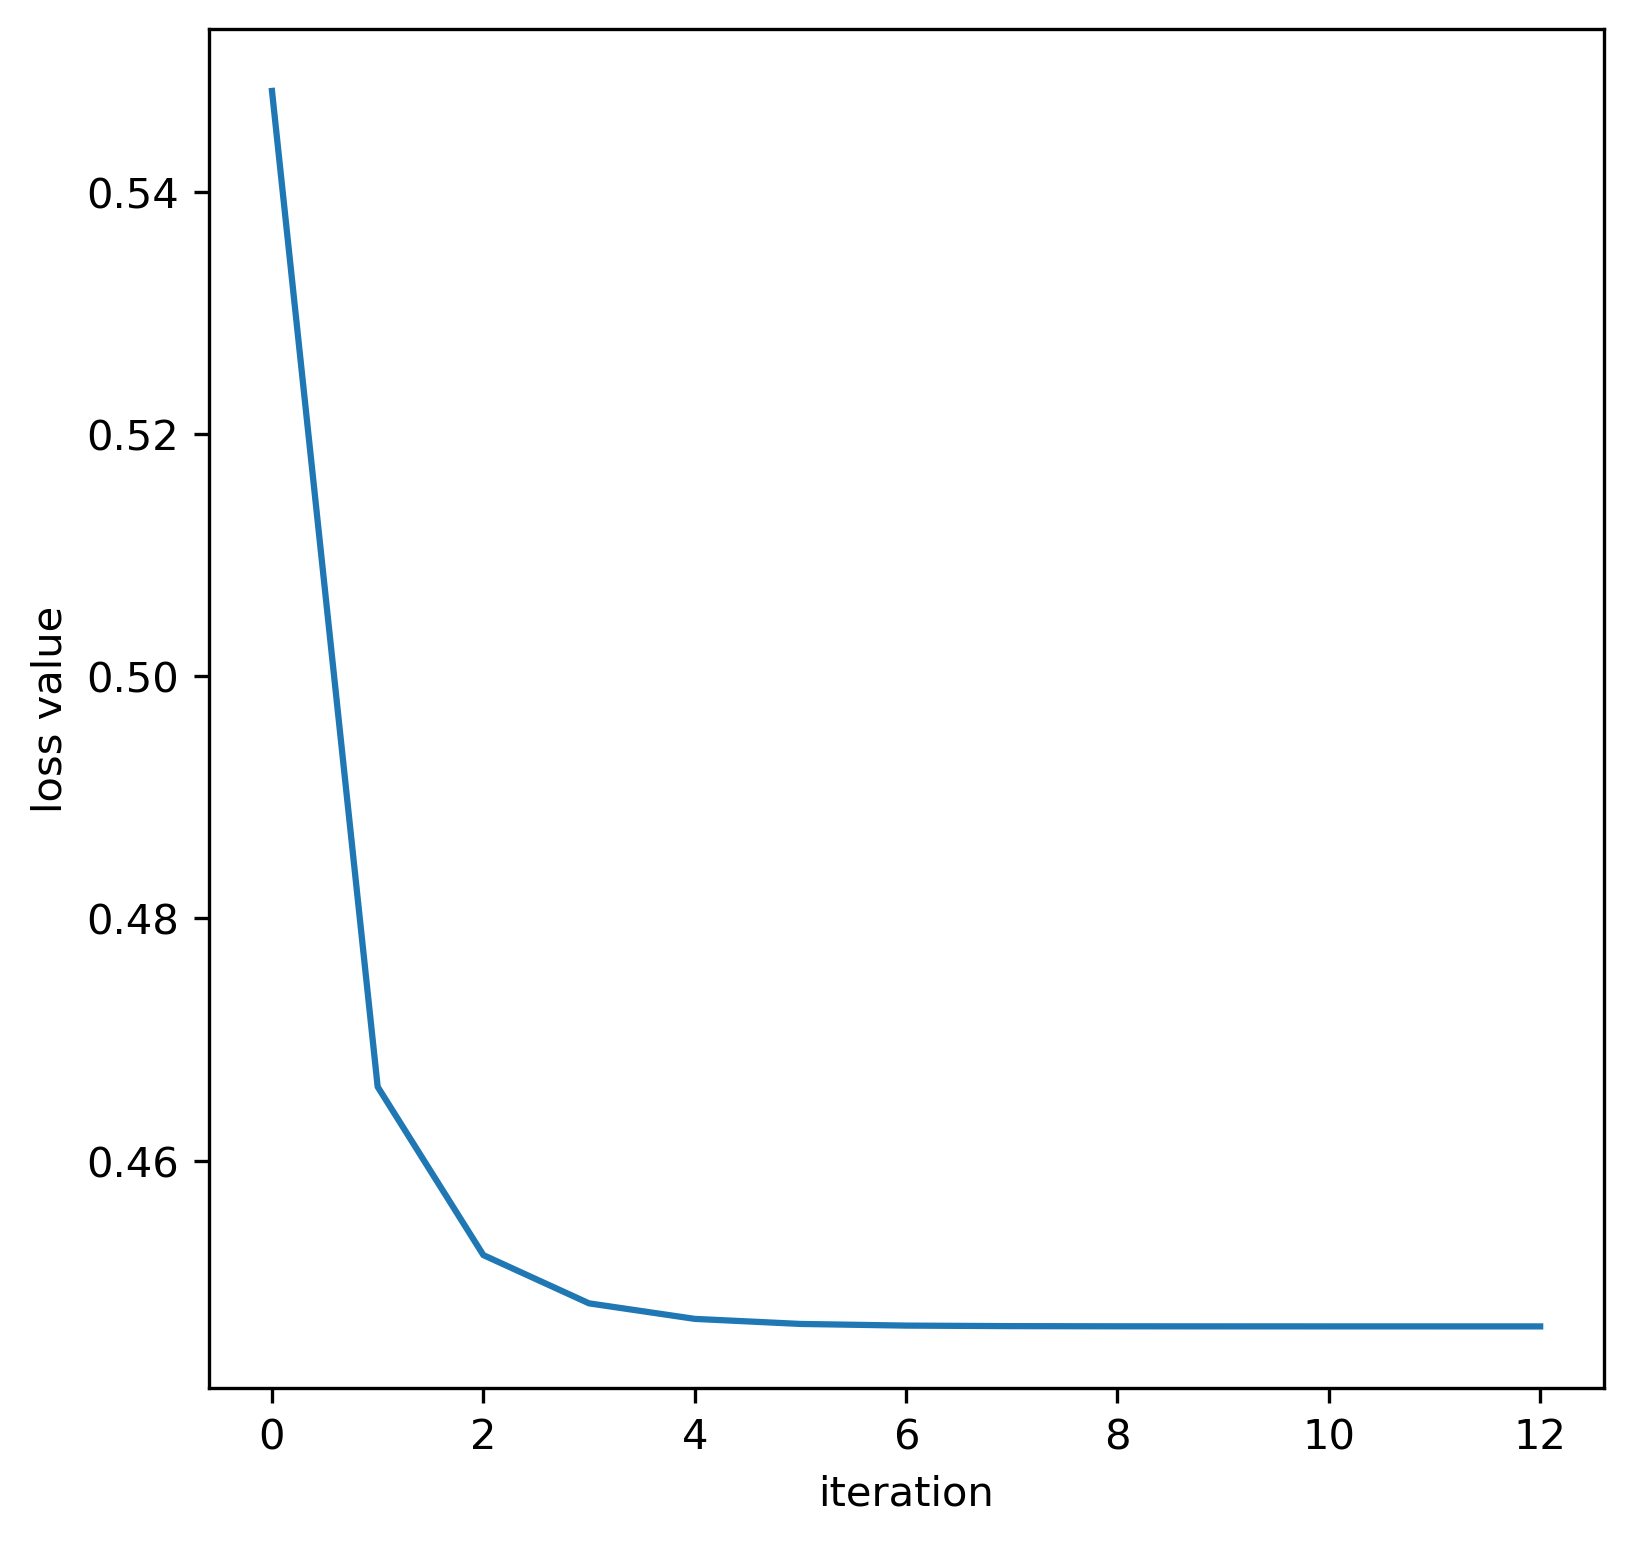

In [49]:
plt.plot(np.arange(len(loss_history)), np.array(loss_history))
plt.xlabel('iteration')
_ = plt.ylabel('loss value')

### Еще больше?

In [50]:
eta = 0.9
eps = 0.0000001

In [51]:
theta_history = []
loss_history = []
grad_history = []

theta_t = theta0
loss_t = loss(Xtrain, ytrain, theta_t)

it = 0

while True:
    it += 1    
    grad_t = loss_grad(Xtrain, ytrain, theta_t)
    theta_t_plus_1 = theta_t - eta*grad_t
    loss_t_plus_1 = loss(Xtrain, ytrain, theta_t_plus_1)
    
    C = np.abs(loss_t_plus_1 - loss_t) < eps
    
    theta_history.append(theta_t)
    loss_history.append(loss_t)
    grad_history.append(grad_t)
    
    loss_t = loss_t_plus_1
    theta_t = theta_t_plus_1
    
    if C & (it > 1):
        break
    
    if it > 1000:
        break

In [52]:
len(loss_history)

1001

Text(0.5, 1.0, 'optimization history')

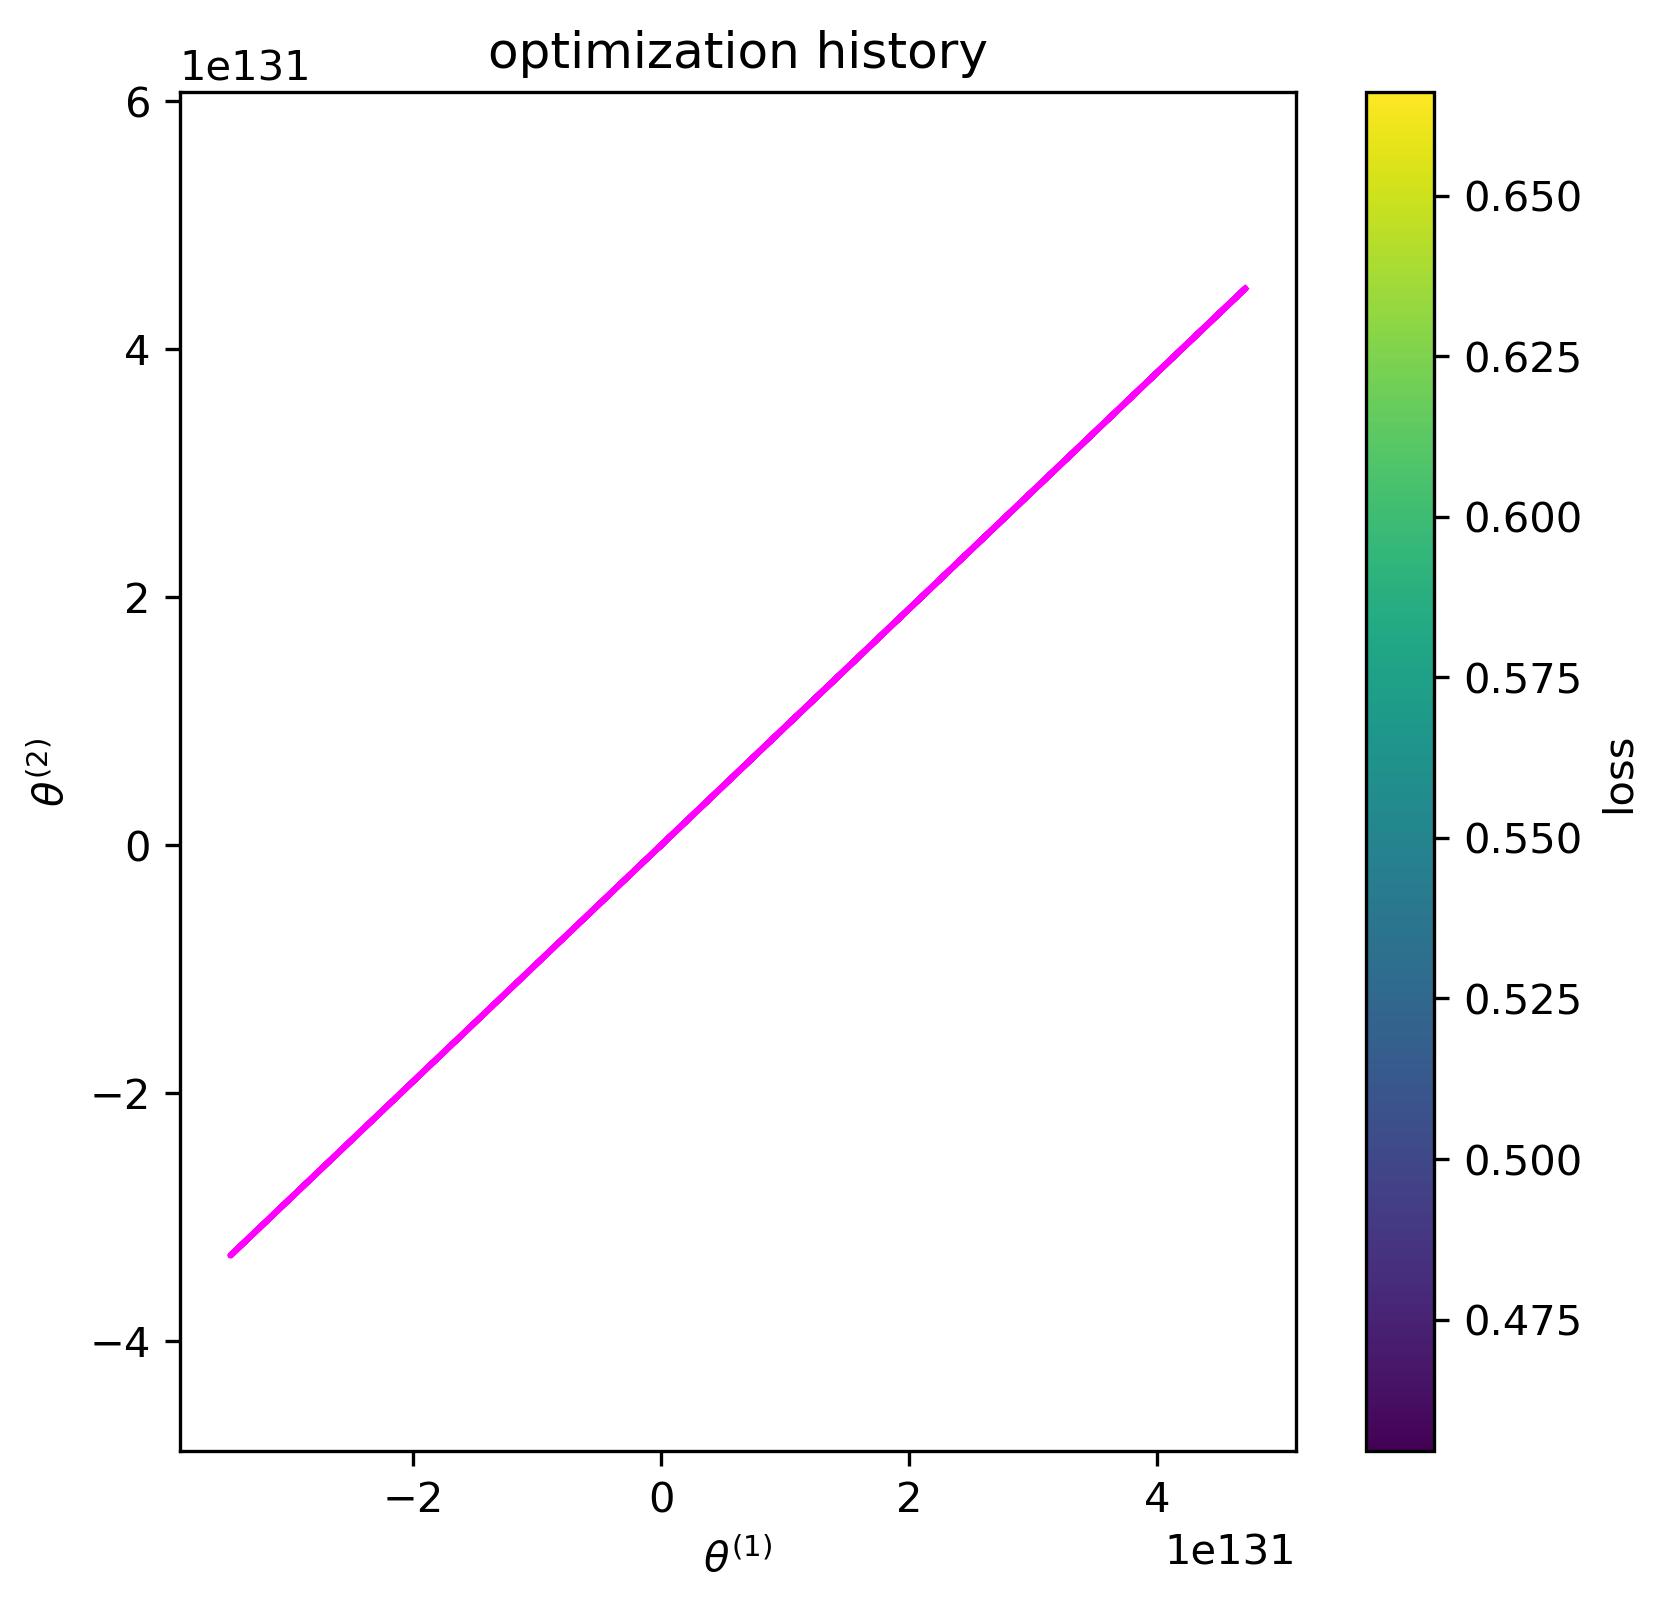

In [53]:
pcm = plt.pcolormesh(t1_mesh, t2_mesh, loss_values)
plt.contour(t1_mesh,
            t2_mesh,
            loss_values,
            levels = np.linspace(loss_values.min(),
                                 loss_values.max(), 20),
            cmap='jet')
plt.xlabel('$\\theta^{(1)}$')
plt.ylabel('$\\theta^{(2)}$')

cb = plt.colorbar(pcm)
cb.set_label('loss')

plt.plot([t[1] for t in theta_history], 
         [t[2] for t in theta_history], color='magenta')

_ = plt.axis('equal')
plt.title('optimization history')

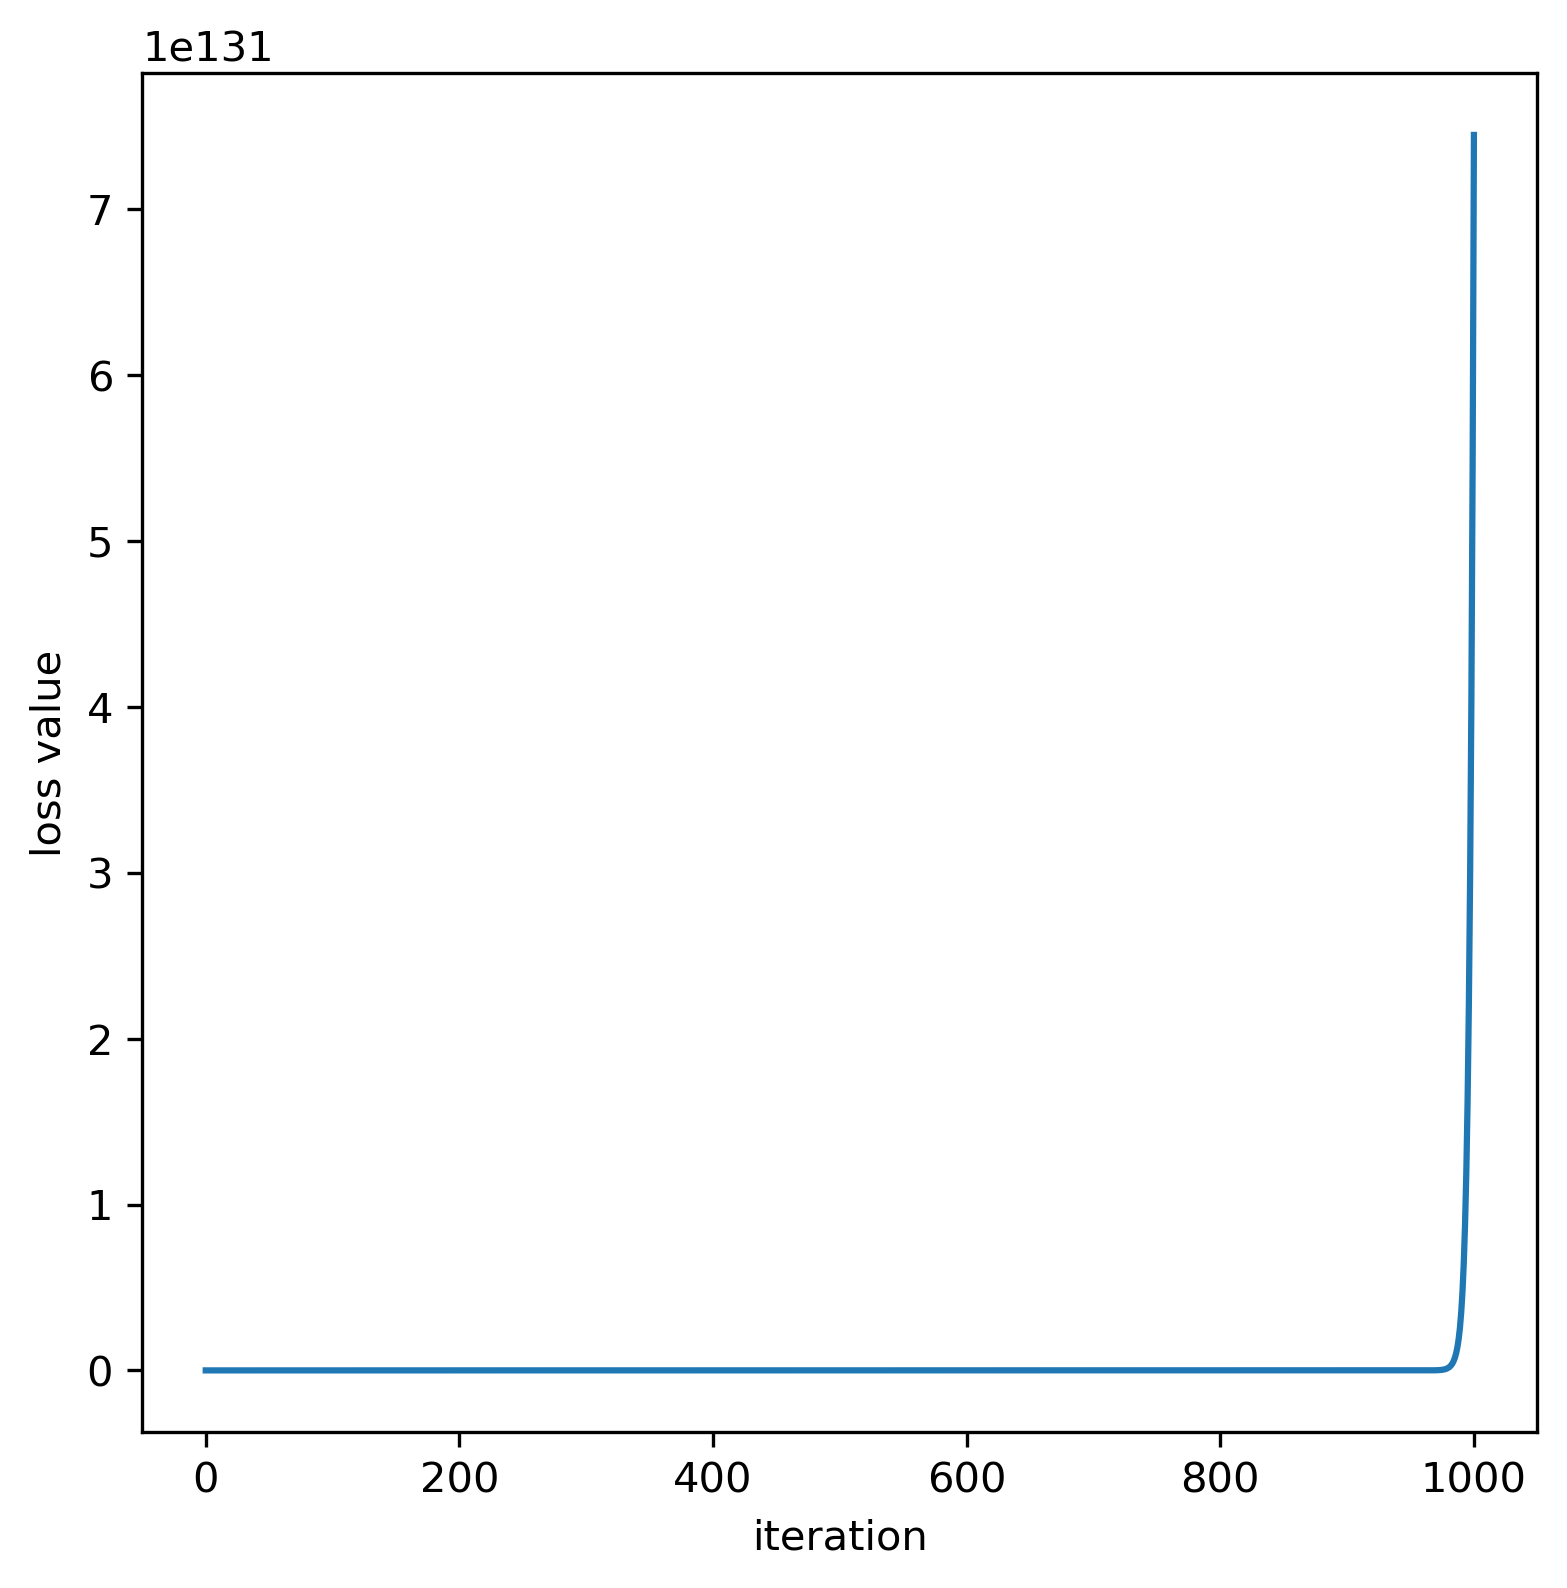

In [54]:
plt.plot(np.arange(len(loss_history)), np.array(loss_history))
plt.xlabel('iteration')
_ = plt.ylabel('loss value')

### Упс. Вообще не сходится.

## Выводы?

## Способы улучшения и ускорения градиентных методов оптимизации 1-го порядка

### - Нормализация данных:<br />

        min-max нормализация:
$$
x^{(j)} = \frac{x^{(j)} - min(x^{(j)})}{max(x^{(j)}) - min(x^{(j)})}
$$
<br />

        стандартизация:
$$
x^{(j)} = \frac{x^{(j)} - mean(x^{(j)})}{std(x^{(j)})}
$$


### - Порядок предъявления объектов (hard negative mining)
(более подробно - в разделе классификации и в разделах нейросетей)

### - Квадратичная (L2) регуляризация коэффициентов:

$$
\mathscr{L}(\theta, X, Y) = \left(Y-X\cdot\theta\right)^T\cdot(Y-X\cdot\theta) + \frac{\lambda}{2}* || \theta || 
$$

В этом случае градиент поменяется! Как именно?

### - Подбор и регулировка шага обучения $\eta$ (learning rate schedule)

Простейший способ регулировки:
$$
\eta^{(t)} = \eta^{(0)}*\frac{1}{t}
$$

### - Обработка локальных минимумов
Если наблюдается стабилизация функции ошибки и есть подозрение, что достигнут не лучший (локальный) минимум, - можно случайным образом модифицировать вектор весов небольшим приращением, чтобы "выбить" его из локального минимума.

### - Стохастические алгоритмы оптимизации

- Если все данные не умещаются в память;
- Если слишком дорого считать значение функции и градиент в каждой точке по всему набору данных;